In [3]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
import sys
from functools import partial 
from scipy import stats, optimize
import scipy
from tqdm import tqdm
from appstatpy.ExternalFunctions import *
from appstatpy.LatexFunctions import *
from sympy import *

### Let $x = 1.023 ± 0.014$ and $y = 0.07 ± 0.23$, and let $z_1 = xy exp(−y)$ and $z_2 = (x − 1)(y + 1)^3$

- What are the uncertainties of z1 and z2 , if x and y are correlated with ρ = 0.4?
  Here we can use two approaches analytical and simulation.

  Analytical:
  Using the errorpropagation formula we
  $$\sigma_{z_1} = \sqrt{\left(\frac{\delta z_1}{\delta x} \sigma_x \right)^2 +  \left(\frac{\delta z_1}{\delta y} \sigma_y\right)^2} = \sqrt{\sigma_x^2 y^2 e^{-2y} + \sigma_y^2 (-xye^{-y}+ xe^{-y})^2}$$


The get the contribution of $x$ and $y$, assume $\sigma_y^2 = 0$ and $\sigma_x^2 = 0$ in above equations, respectively. So, you get $z_1=0.067 \pm 0.206$ and:
\begin{tabular}{c|c} 
  \hline
  \hline
  Variable & Influence on $z_1$ \\
  $x$ & 9.137$\times$10$^{-4}$ \\ 
  $y$ & 0.206 \\
  \hline 
  \hline
\end{tabular}

  

- In the correlated case with $\rho = 0.4$, the error propagation changes to:
\begin{align*}
\sigma_{z_1} = \sqrt{\sigma_x^2y^2e^{-2y}+2Vy(-xye^{-y}+xe^{-y})e^{-y}+\sigma_y^2(-xye^{-y}+xe^{-y})^2} = 0.206
\end{align*}
and,
\begin{align*}
\sigma_{z_2} = \sqrt{\frac{\sigma_x^2(y+1)^6}{(x-1)^4}-\frac{6V(y+1)^5}{(x-1)^3}+\frac{9\sigma_y^2(y+1)^4}{(x-1)^2}} = 22.792
\end{align*}
where, $V = \rho\sigma_x\sigma_y$.
    

- What is the Pearson correlation between z1 and z2 for z1 ∈ [−1, 1] and z2 ∈ [−1, 1]?

This problem can be abit tricky as the sampling of Z1 and Z2 in this interval is not stragight forward. One thing to keep in mind, is that we now can sample freely in x and y, and is thus not limited to the the distribution shown in the previous two problems. 

Looking at the formulas for both, it is not clear for neither what values of x and y will give us results that land in the desired interval for any of the two intervals. Instead we introduce a brute force version of the accept reject method. We dont have any idea about how we should draw a bounding box, so instead we try to scan for values where we can find the desired interval. This is seen in the heatmaps below. In these heatmaps we observe that we sample the entire interval for Z1 and Z2, so we use the limits of these to pick random numbers. To yield good statistics we look for 2000 samples using a while loop. When using a while loop it can be wise to put a counter to prevent the script to cotinue forever, as these problems otherwise are prone to do. In the end we end up with an efficiancy of around 10%. 

From this we plug the numbers into the formula for the spearman correlation and observe that we have a slight negative correlation between the two. Here we have used our own version of the spearman correlation, but we could as well have used a packages

20066


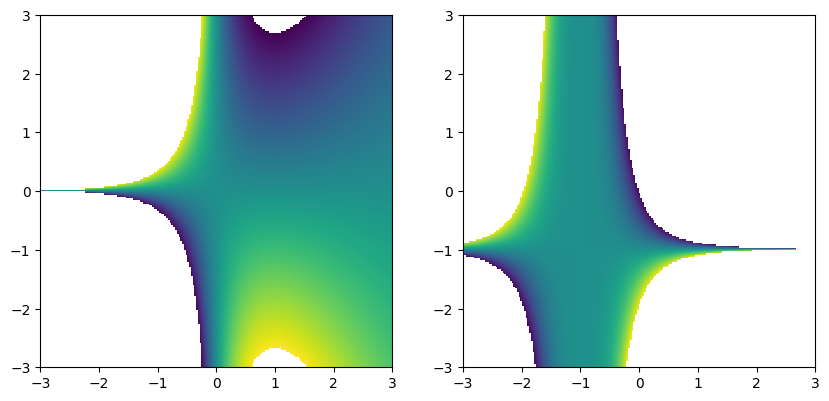

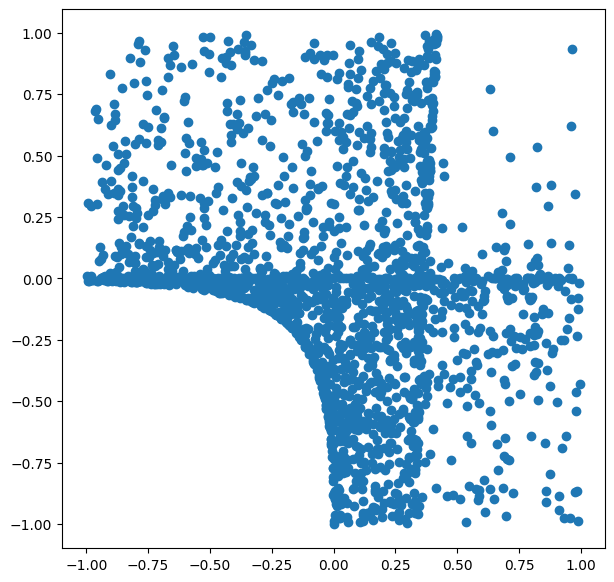

In [54]:
def z1(x,y):
    return x*y*np.exp(-y)

def z2(x,y):
    return (y+1)**3*(x -1)

x = np.linspace(-3, 3, 200)

img1 = np.zeros((200,200))
img2 = np.zeros((200,200))


for i in range(200):
    for j in range(200):
        img1[i,j] = z1(x[i], x[j])
        img2[i,j] = z2(x[i], x[j])

img1[img1 > 1] = np.nan
img1[img1 < -1] = np.nan

img2[img2 > 1] = np.nan
img2[img2 < -1] = np.nan


fig, ax = plt.subplots(1,2, figsize = (10, 7))
ax[0].imshow(img1, vmin = -1, vmax = 1, extent = [x.min(),x.max(),x.min(),x.max()])
ax[1].imshow(img2, vmin = -1, vmax = 1, extent = [x.min(),x.max(),x.min(),x.max()])


N = 2000
n = 0
idx = 0

Zs = np.zeros((2,N))

while n != N:
    x = np.random.uniform(-3,3,1)[0]
    y = np.random.uniform(-3,3,1)[0]
    Z1 = z1(x,y)
    Z2 = z2(x,y)
    #print(Z1, Z2)
    if Z1 > -1 and Z1 < 1:
        if Z2 > -1 and Z2 < 1:
            Zs[0,n] = Z1
            Zs[1,n] = Z2
            n += 1
    idx += 1
    if idx > 10000000:
        print(n)
        break
print(idx)

fig, ax = plt.subplots(1,1, figsize = (7,7))
ax.scatter(Zs[0,:], Zs[1,:])







In [37]:
def spearman(var1, var2):
    sig_1 = np.std(var1)
    sig_2 = np.std(var2)
    mean1 = np.mean(var1)
    mean2 = np.mean(var2)
    covariance = 1/len(var1) * np.sum((var1 - mean1)*(var2 - mean2))
    return covariance / (sig_1 * sig_2)

print(spearman(Zs[0,:], Zs[1,:]))

-0.2668072118150737
